In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('orders.csv')
df.head()

,task_id,order_id,customer_id,restaurant_id,city,restaurant_address_lng,restaurant_address_lat,delivery_address_lng,delivery_address_lat,order_state,order_promised_delivery,restaurant_finished_preparation
0,1,1,15116,721,Bucharest,26.074823,44.415090,26.014888,44.428852,delivered,2021-10-15T03:31:11.000Z,2021-10-15T03:08:44.000Z
1,1,2,12572,1445,Bucharest,26.054794,44.454021,26.093656,44.434069,delivered,2021-10-15T03:46:07.000Z,2021-10-15T03:24:22.000Z
2,1,3,34814,891,Bucharest,26.049776,44.424410,26.020117,44.411906,delivered,2021-10-15T04:00:30.000Z,2021-10-15T03:45:39.000Z
3,1,4,17168,368,Bucharest,26.143047,44.430457,26.126890,44.417530,delivered,2021-10-15T04:15:53.000Z,2021-10-15T04:08:40.000Z
4,1,5,35129,721,Bucharest,26.074823,44.415090,26.030227,44.433221,delivered,2021-10-15T04:44:42.000Z,2021-10-15T04:28:17.000Z


In [3]:
print ('The data has {0} rows and {1} columns'.format(df.shape[0],df.shape[1]))

The data has 65584 rows and 12 columns


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65584 entries, 0 to 65583
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   task_id                          65584 non-null  int64  
 1   order_id                         65584 non-null  int64  
 2   customer_id                      65584 non-null  int64  
 3   restaurant_id                    65584 non-null  int64  
 4   city                             65584 non-null  object 
 5   restaurant_address_lng           65584 non-null  float64
 6   restaurant_address_lat           65584 non-null  float64
 7   delivery_address_lng             65584 non-null  float64
 8   delivery_address_lat             65584 non-null  float64
 9   order_state                      65584 non-null  object 
 10  order_promised_delivery          65584 non-null  object 
 11  restaurant_finished_preparation  65525 non-null  object 
dtypes: float64(4), int

In [5]:
# Selecting duplicate rows except first 
# occurrence based on all columns
duplicate = df[df.duplicated()]
print("Duplicate Rows:", duplicate.shape[0])

Duplicate Rows: 0


In [6]:
## check missing values
df.columns[df.isnull().any()]

Index(['restaurant_finished_preparation'], dtype='object')

In [7]:
del df['task_id']
df[df['restaurant_finished_preparation'].isnull()]['order_state'].value_counts()

order_state
failed    59
Name: count, dtype: int64

In [8]:
df['order_state'].value_counts()

order_state
delivered    65473
failed         111
Name: count, dtype: int64

In [9]:
df['order_state'].value_counts(normalize=True).mul(100)

order_state
delivered    99.830751
failed        0.169249
Name: proportion, dtype: float64

In [10]:
df = df[~df['restaurant_finished_preparation'].isnull()]

In [11]:
## handle timestamps
df['order_promised_delivery'] = pd.to_datetime(df['order_promised_delivery'])
df['restaurant_finished_preparation'] = pd.to_datetime(df['restaurant_finished_preparation'])

In [12]:
print(df['order_promised_delivery'].min(),df['order_promised_delivery'].max())

2021-10-15 03:31:11+00:00 2021-11-19 03:47:43+00:00


In [13]:
## separate variables into new data frames
df['restaurant_id'] = df['restaurant_id'].astype('object')
df['order_id'] = df['order_id'].astype('object')
df['customer_id'] = df['customer_id'].astype('object')
cat_data = df.select_dtypes(exclude=[np.number])
del cat_data['order_promised_delivery']
del cat_data['restaurant_finished_preparation']

In [14]:
cat_data.describe().transpose()

,count,unique,top,freq
order_id,65525,65525,1,1
customer_id,65525,43633,36243,16
restaurant_id,65525,1505,1460,682
city,65525,1,Bucharest,65525
order_state,65525,2,delivered,65473


In [15]:
df = df[df['order_state']=='delivered']
orders_count = df[['restaurant_id','order_id']].groupby('restaurant_id').nunique().reset_index()
orders_count.head()

,restaurant_id,order_id
0,1,3
1,2,2
2,3,57
3,4,1
4,5,121


In [16]:
from math import radians, sin, cos, sqrt, atan2

def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [17]:
#distance between restaurant and delivery address

df['distance_km'] = df.apply(
    lambda row: calculate_distance(row['restaurant_address_lat'], row['restaurant_address_lng'], 
                                   row['delivery_address_lat'], row['delivery_address_lng']), axis=1)

In [18]:
df['distance_km'].describe(percentiles=[0.25,0.5,0.75,0.9,0.95])

count    65473.000000
mean         2.412005
std          1.780085
min          0.000000
25%          1.062222
50%          1.985768
75%          3.290129
90%          4.901536
95%          6.024420
max         12.562621
Name: distance_km, dtype: float64

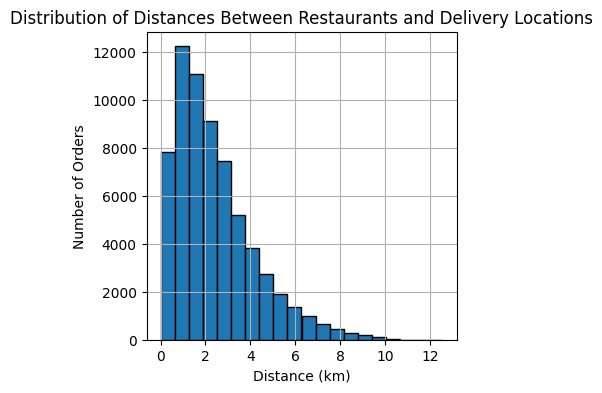

In [19]:
# Create a histogram of distances
plt.figure(figsize=(4, 4))
plt.hist(df['distance_km'], bins=20, edgecolor='black')
plt.title('Distribution of Distances Between Restaurants and Delivery Locations')
plt.xlabel('Distance (km)')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

In [20]:
## restaurant clustering based on lat and lng 
restaurants_df = df[['restaurant_id', 'restaurant_address_lat', 'restaurant_address_lng']].drop_duplicates()
restaurants_df.columns = ['restaurant_id', 'latitude', 'longitude']

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Extract the latitude and longitude
X = restaurants_df[['latitude', 'longitude']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

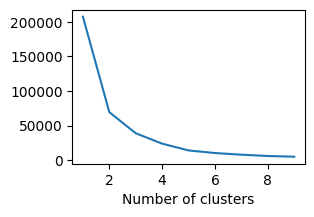

In [22]:
sse={}

segment = df.copy()

df_dist = segment[['distance_km']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_dist)
    df_dist["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure(figsize=(3,2))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [23]:
n_clusters = 3  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
restaurants_df['cluster'] = kmeans.fit_predict(X_scaled)

In [24]:
df = df.merge(restaurants_df[['restaurant_id', 'cluster']], on='restaurant_id', how='left')
df = df.drop_duplicates()
orders_count = orders_count.merge(restaurants_df[['restaurant_id', 'cluster']], on='restaurant_id', how='left')

In [25]:
def boxplot(x,y,**kwargs):
            sns.boxplot(x=x,y=y)
            x = plt.xticks()
            
df[['restaurant_id','cluster']].groupby('cluster').nunique()

,restaurant_id
cluster,
0,571
1,602
2,334


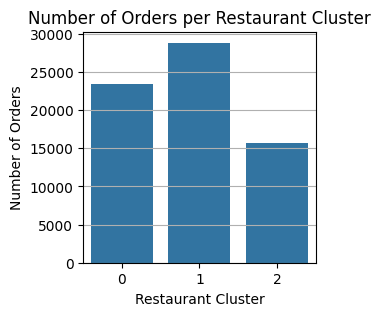

In [26]:
order_counts = orders_count.groupby('cluster')['order_id'].sum().reset_index()
order_counts.columns = ['cluster', 'number_of_orders']

plt.figure(figsize=(3, 3))
sns.barplot(x='cluster', y='number_of_orders', data=order_counts)
plt.title('Number of Orders per Restaurant Cluster')
plt.xlabel('Restaurant Cluster')
plt.ylabel('Number of Orders')
plt.grid(axis='y')
plt.show()

In [27]:
df1 = pd.read_csv('order_stages.csv')
final_df = df1.copy()
df1.head()

,log_id,city,order_id,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,task_id
0,1,Bucharest,1,677,motorbike,order_proposed_to_courier,2021-10-15 03:04:02.000,26.082872,44.416126,NaN,NaN,649.953324,NaN,2021-10-15 03:27:30.000,1
1,2,Bucharest,1,677,motorbike,courier_accepts_order,2021-10-15 03:04:12.000,26.082872,44.416126,218.0,NaN,649.953324,NaN,2021-10-15 03:27:10.000,1
2,3,Bucharest,1,677,motorbike,courier_arrived_at_restaurant,2021-10-15 03:08:51.000,26.074600,44.414964,NaN,NaN,22.596096,NaN,2021-10-15 03:26:36.000,1
3,4,Bucharest,1,677,motorbike,courier_picked_up_order,2021-10-15 03:08:54.000,26.074581,44.414966,NaN,756.0,23.668382,4988.52796,2021-10-15 03:24:39.000,1
4,5,Bucharest,2,1970,motorbike,order_proposed_to_courier,2021-10-15 03:24:02.000,26.040890,44.479828,NaN,NaN,3076.131080,NaN,2021-10-15 03:46:36.000,1


In [28]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384937 entries, 0 to 384936
Data columns (total 15 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   log_id                                          384937 non-null  int64  
 1   city                                            384937 non-null  object 
 2   order_id                                        384937 non-null  int64  
 3   courier_id                                      384937 non-null  int64  
 4   vehicle_type                                    384937 non-null  object 
 5   order_stage                                     384937 non-null  object 
 6   order_stage_start                               384937 non-null  object 
 7   courier_location_lng_at_start                   384860 non-null  float64
 8   courier_location_lat_at_start                   384860 non-null  float64
 9   estimated_travel_time_in_s

In [29]:
print(final_df['order_stage_start'].min(),final_df['order_stage_start'].max())

2021-10-15 03:04:02.000 2021-11-19 03:45:27.000


In [30]:
final_df['courier_id'] = final_df['courier_id'].astype('object')
final_df['order_id'] = final_df['order_id'].astype('object')
cat_data = final_df.select_dtypes(exclude=[np.number])
cat_data.describe().transpose()

,count,unique,top,freq
city,384937,1,Bucharest,384937
order_id,384937,64205,1,6
courier_id,384937,3039,2528,738
vehicle_type,384937,3,motorbike,276084
order_stage,384937,6,order_proposed_to_courier,64205
order_stage_start,384937,337410,2021-11-11 13:03:38.000,7
updated_expected_delivery_time,320158,241711,2021-10-18 15:43:29.000,10


In [31]:
final_df['vehicle_type'].value_counts()

vehicle_type
motorbike    276084
bicycle       77743
car           31110
Name: count, dtype: int64

In [32]:
final_df['vehicle_type'].value_counts(normalize=True).mul(100)

vehicle_type
motorbike    71.721866
bicycle      20.196292
car           8.081842
Name: proportion, dtype: float64

In [33]:
final_df['order_stage'].value_counts()

order_stage
order_proposed_to_courier        64205
courier_accepts_order            64178
courier_arrived_at_restaurant    64169
courier_picked_up_order          64136
courier_arrived_at_customer      64125
courier_delivered_order          64124
Name: count, dtype: int64

In [34]:
df1['courier_propose_order'] =  np.where(df1['order_stage']=='order_proposed_to_courier', df1['order_stage_start'],0)
df1['courier_accept_order'] =  np.where(df1['order_stage']=='courier_accepts_order', df1['order_stage_start'],0)
df1['courier_reach_restaurant'] =  np.where(df1['order_stage']=='courier_arrived_at_restaurant', df1['order_stage_start'],0)
df1['courier_pick_order'] =  np.where(df1['order_stage']=='courier_picked_up_order', df1['order_stage_start'],0)
df1['actual_delivery_time'] = np.where(df1['order_stage']=='courier_arrived_at_customer', df1['order_stage_start'],0)
df1['courier_propose_order']=pd.to_datetime(df1['courier_propose_order'],format='mixed')
df1['courier_accept_order']=pd.to_datetime(df1['courier_accept_order'])
df1['courier_pick_order']=pd.to_datetime(df1['courier_pick_order'])
df1['courier_reach_restaurant']=pd.to_datetime(df1['courier_reach_restaurant'])
df1['updated_expected_delivery_time']=pd.to_datetime(df1['updated_expected_delivery_time'])
df1['actual_delivery_time']=pd.to_datetime(df1['actual_delivery_time'])

In [35]:
#max_values.head()

In [36]:
z = df1[['courier_id','order_id','updated_expected_delivery_time','distance_courier_to_restaurant_address','order_stage_start']]
max_values = df1[df1['order_stage']=='courier_arrived_at_customer'].groupby('order_id')[['order_stage_start','updated_expected_delivery_time']].max().reset_index()

result = pd.merge(z[['courier_id','updated_expected_delivery_time','order_id','distance_courier_to_restaurant_address','order_stage_start']], max_values, on=['order_id', 'order_stage_start','updated_expected_delivery_time'],how = 'right')
result = result[['order_id','updated_expected_delivery_time','courier_id']].drop_duplicates()
result.head()


,order_id,updated_expected_delivery_time,courier_id
0,1,2021-10-15 03:38:01,677
1,2,2021-10-15 03:44:47,1970
2,3,2021-10-15 04:16:48,843
3,4,2021-10-15 04:19:52,2410
4,5,2021-10-15 04:45:54,2588


In [37]:
c = df1[['order_id','vehicle_type','actual_delivery_time','courier_propose_order','courier_accept_order','courier_reach_restaurant','courier_pick_order','distance_courier_to_restaurant_address']].groupby(['order_id','vehicle_type']).max().reset_index()

In [38]:
df_final = pd.merge(df,c,on=['order_id'],how='left')
df_final = pd.merge(df_final,result,on=['order_id'],how='left')
df_final['actual_delivery_time'] = np.where(df_final['actual_delivery_time']==0,df_final['updated_expected_delivery_time'],df_final['actual_delivery_time'])
df_final.head()

,order_id,customer_id,restaurant_id,city,restaurant_address_lng,restaurant_address_lat,delivery_address_lng,delivery_address_lat,order_state,order_promised_delivery,...,cluster,vehicle_type,actual_delivery_time,courier_propose_order,courier_accept_order,courier_reach_restaurant,courier_pick_order,distance_courier_to_restaurant_address,updated_expected_delivery_time,courier_id
0,1,15116,721,Bucharest,26.074823,44.415090,26.014888,44.428852,delivered,2021-10-15 03:31:11+00:00,...,2,motorbike,2021-10-15 03:38:01,2021-10-15 03:04:02,2021-10-15 03:04:12,2021-10-15 03:08:51,2021-10-15 03:08:54,649.953324,2021-10-15 03:38:01,677.0
1,2,12572,1445,Bucharest,26.054794,44.454021,26.093656,44.434069,delivered,2021-10-15 03:46:07+00:00,...,2,motorbike,2021-10-15 03:44:47,2021-10-15 03:24:02,2021-10-15 03:24:21,2021-10-15 03:30:21,2021-10-15 03:34:49,3076.131080,2021-10-15 03:44:47,1970.0
2,3,34814,891,Bucharest,26.049776,44.424410,26.020117,44.411906,delivered,2021-10-15 04:00:30+00:00,...,2,motorbike,2021-10-15 04:16:48,2021-10-15 03:33:42,2021-10-15 03:34:01,2021-10-15 03:46:56,2021-10-15 03:48:19,2133.587165,2021-10-15 04:16:48,843.0
3,4,17168,368,Bucharest,26.143047,44.430457,26.126890,44.417530,delivered,2021-10-15 04:15:53+00:00,...,1,motorbike,2021-10-15 04:19:52,2021-10-15 03:55:32,2021-10-15 03:55:50,2021-10-15 04:10:18,2021-10-15 04:12:12,542.873720,2021-10-15 04:19:52,2410.0
4,5,35129,721,Bucharest,26.074823,44.415090,26.030227,44.433221,delivered,2021-10-15 04:44:42+00:00,...,2,car,2021-10-15 04:45:54,2021-10-15 04:14:42,2021-10-15 04:14:49,2021-10-15 04:23:50,2021-10-15 04:29:34,2658.265610,2021-10-15 04:45:54,2588.0


In [39]:
df_final['courier_id'].astype('object').nunique()

3034

In [40]:
df_final['courier_id'] = df_final['courier_id'].astype('object')
df_final['courier_id'].describe()

count     64228.0
unique     3034.0
top        2528.0
freq        125.0
Name: courier_id, dtype: float64

In [41]:
print ('The data has {0} rows and {1} columns'.format(df_final.shape[0],df_final.shape[1]))

The data has 65577 rows and 22 columns


In [42]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65577 entries, 0 to 65576
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype              
---  ------                                  --------------  -----              
 0   order_id                                65577 non-null  object             
 1   customer_id                             65577 non-null  object             
 2   restaurant_id                           65577 non-null  object             
 3   city                                    65577 non-null  object             
 4   restaurant_address_lng                  65577 non-null  float64            
 5   restaurant_address_lat                  65577 non-null  float64            
 6   delivery_address_lng                    65577 non-null  float64            
 7   delivery_address_lat                    65577 non-null  float64            
 8   order_state                             65577 non-null  object             


In [43]:
# Selecting duplicate rows except first 
# occurrence based on all columns
duplicate = df_final[df_final.duplicated()]
print("Duplicate Rows:", duplicate.shape[0])

Duplicate Rows: 0


In [44]:
##numberofordervsestimated_timetaken_delivery
##clustervsestimated_timetaken_delivery

In [45]:
df_final['order_promised_delivery'] = pd.to_datetime(df_final['order_promised_delivery']).dt.tz_localize(None)
df_final['estimated_timetaken_delivery'] = (df_final['order_promised_delivery'] - df_final['courier_pick_order']).dt.total_seconds() / 60

In [46]:
df_final[df_final['order_state']=='delivered']['estimated_timetaken_delivery'].describe(percentiles=[0.25,0.5,0.75,0.9,0.95])

count    64228.000000
mean        13.046048
std          8.599941
min        -91.733333
25%          8.333333
50%         12.916667
75%         17.883333
90%         23.250000
95%         26.966667
max         56.000000
Name: estimated_timetaken_delivery, dtype: float64

In [47]:
## check missing values
final_df.columns[final_df.isnull().any()]

Index(['courier_location_lng_at_start', 'courier_location_lat_at_start',
       'estimated_travel_time_in_seconds_to_restaurant',
       'estimated_travel_time_in_seconds_to_eater',
       'distance_courier_to_restaurant_address',
       'distance_courier_to_customer_address',
       'updated_expected_delivery_time'],
      dtype='object')

In [48]:
final_df[final_df['order_id']==1].sort_values(by='order_stage_start')

,log_id,city,order_id,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,task_id
0,1,Bucharest,1,677,motorbike,order_proposed_to_courier,2021-10-15 03:04:02.000,26.082872,44.416126,NaN,NaN,649.953324,NaN,2021-10-15 03:27:30.000,1
1,2,Bucharest,1,677,motorbike,courier_accepts_order,2021-10-15 03:04:12.000,26.082872,44.416126,218.0,NaN,649.953324,NaN,2021-10-15 03:27:10.000,1
2,3,Bucharest,1,677,motorbike,courier_arrived_at_restaurant,2021-10-15 03:08:51.000,26.074600,44.414964,NaN,NaN,22.596096,NaN,2021-10-15 03:26:36.000,1
3,4,Bucharest,1,677,motorbike,courier_picked_up_order,2021-10-15 03:08:54.000,26.074581,44.414966,NaN,756.0,23.668382,4988.527960,2021-10-15 03:24:39.000,1
10,11,Bucharest,1,677,motorbike,courier_arrived_at_customer,2021-10-15 03:38:01.000,26.015199,44.428529,NaN,NaN,NaN,43.611625,2021-10-15 03:38:01.000,1
18,19,Bucharest,1,677,motorbike,courier_delivered_order,2021-10-15 04:11:53.000,26.035058,44.414040,NaN,NaN,NaN,2298.808468,NaN,1


In [49]:
df_final['restaurant_finished_preparation'] = pd.to_datetime(df_final['restaurant_finished_preparation']).dt.tz_localize(None)
df_final['actual_delivery_time'] = pd.to_datetime(df_final['actual_delivery_time']).dt.tz_localize(None)
df_final['updated_expected_delivery_time'] = pd.to_datetime(df_final['updated_expected_delivery_time']).dt.tz_localize(None)
df_final['updated_expected_delivery_time'] = np.where(df_final['updated_expected_delivery_time'].isnull, df_final['order_promised_delivery'], df_final['updated_expected_delivery_time'])
df_final['updated_timetaken_delivery'] = (df_final['updated_expected_delivery_time'] - df_final['courier_pick_order']).dt.total_seconds() / 60
df_final['actual_timetaken_delivery'] = (df_final['actual_delivery_time'] - df_final['courier_pick_order']).dt.total_seconds() / 60
df_final['order_promised_delivery_time'] = (df_final['order_promised_delivery'] - df_final['courier_pick_order']).dt.total_seconds() / 60

In [50]:
df_final[(df_final['order_id']==1)][['courier_propose_order','courier_accept_order','courier_reach_restaurant','courier_pick_order','order_promised_delivery','updated_expected_delivery_time','actual_delivery_time','restaurant_finished_preparation','updated_timetaken_delivery','actual_timetaken_delivery']]

,courier_propose_order,courier_accept_order,courier_reach_restaurant,courier_pick_order,order_promised_delivery,updated_expected_delivery_time,actual_delivery_time,restaurant_finished_preparation,updated_timetaken_delivery,actual_timetaken_delivery
0,2021-10-15 03:04:02,2021-10-15 03:04:12,2021-10-15 03:08:51,2021-10-15 03:08:54,2021-10-15 03:31:11,2021-10-15 03:31:11,2021-10-15 03:38:01,2021-10-15 03:08:44,22.283333,29.116667


In [51]:
df_final['distance_courier_to_restaurant_address'] = df_final['distance_courier_to_restaurant_address']/1000
df_final['courier_order_propose_accept'] = (df_final['courier_accept_order'] - df_final['courier_propose_order']).dt.total_seconds() / 60
df_final['courier_reach_restaurant_accept_order'] = (df_final['courier_reach_restaurant'] - df_final['courier_accept_order']).dt.total_seconds() / 60
df_final['courier_accept_order_restaurant_prep'] = (df_final['restaurant_finished_preparation'] - df_final['courier_accept_order']).dt.total_seconds() / 60
df_final['courier_reach_restaurant_prep'] = (df_final['courier_reach_restaurant'] - df_final['restaurant_finished_preparation']).dt.total_seconds() / 60
df_final['courier_restaurant_prep_pick_order'] = (df_final['courier_pick_order'] - df_final['restaurant_finished_preparation']).dt.total_seconds() / 60
df_final['courier_reach_restaurant_pick_order'] = (df_final['courier_pick_order'] - df_final['courier_reach_restaurant']).dt.total_seconds() / 60
df_final['total_courier_time'] = df_final['courier_order_propose_accept'] + df_final['courier_reach_restaurant_accept_order'] + df_final['courier_reach_restaurant_prep'] + df_final['courier_restaurant_prep_pick_order'] + df_final['actual_timetaken_delivery']

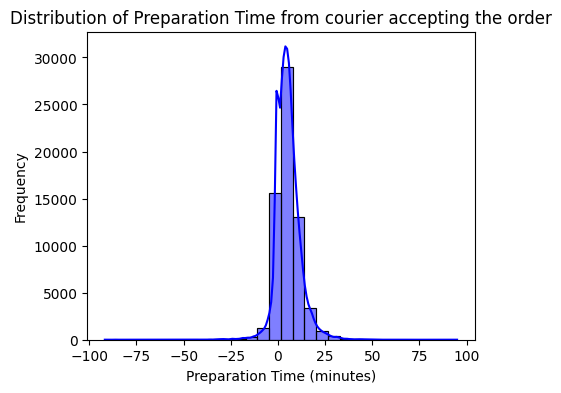

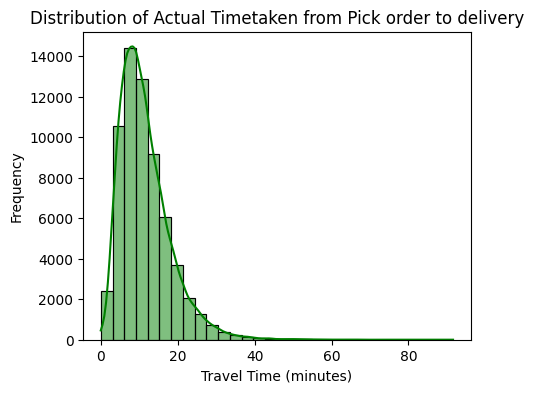

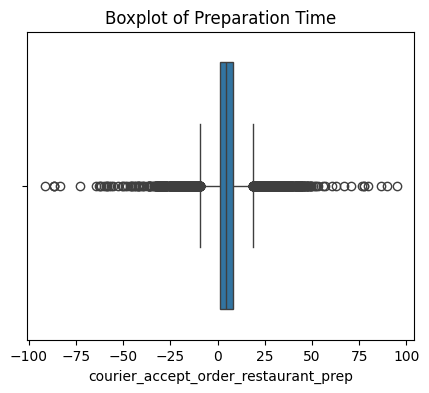

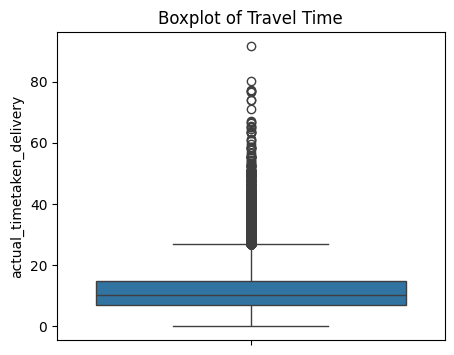

In [52]:
plt.figure(figsize=(5, 4))
sns.histplot(df_final['courier_accept_order_restaurant_prep'], bins=30, kde=True, color='blue')
plt.title('Distribution of Preparation Time from courier accepting the order')
plt.xlabel('Preparation Time (minutes)')
plt.ylabel('Frequency')
plt.show()

# Plot travel time distribution
plt.figure(figsize=(5, 4))
sns.histplot(df_final['actual_timetaken_delivery'], bins=30, kde=True, color='green')
plt.title('Distribution of Actual Timetaken from Pick order to delivery')
plt.xlabel('Travel Time (minutes)')
plt.ylabel('Frequency')
plt.show()

# Boxplot to check for outliers in preparation time
plt.figure(figsize=(5, 4))
sns.boxplot(x='courier_accept_order_restaurant_prep', data=df_final)
plt.title('Boxplot of Preparation Time')
plt.show()

# Boxplot to check for outliers in travel time
plt.figure(figsize=(5, 4))
sns.boxplot(df_final['actual_timetaken_delivery'])
plt.title('Boxplot of Travel Time')
plt.show()


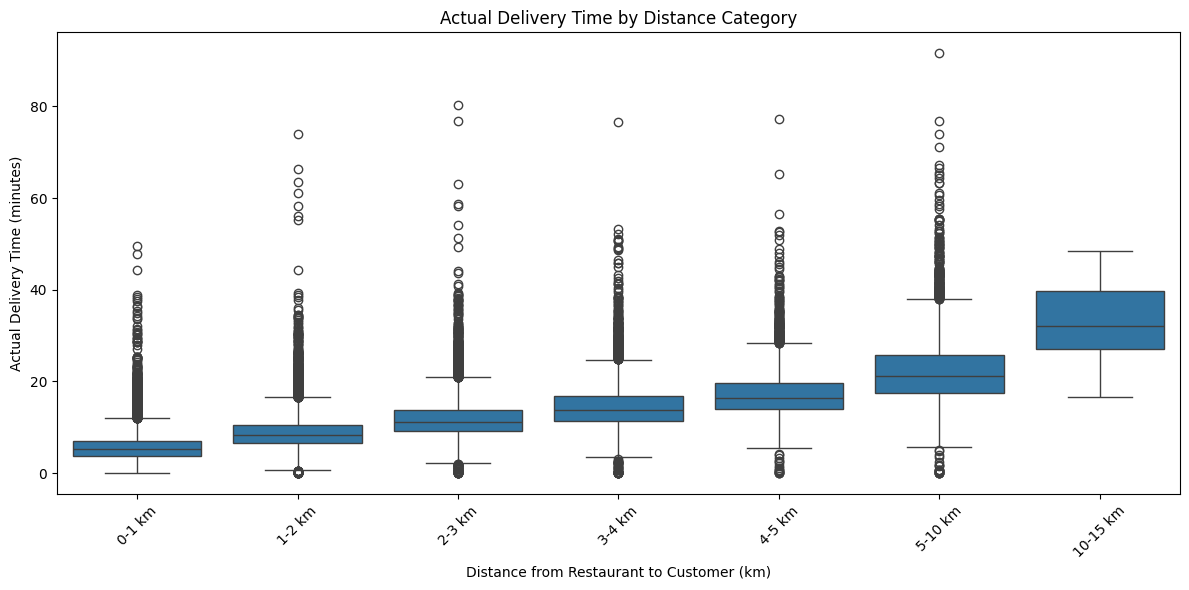

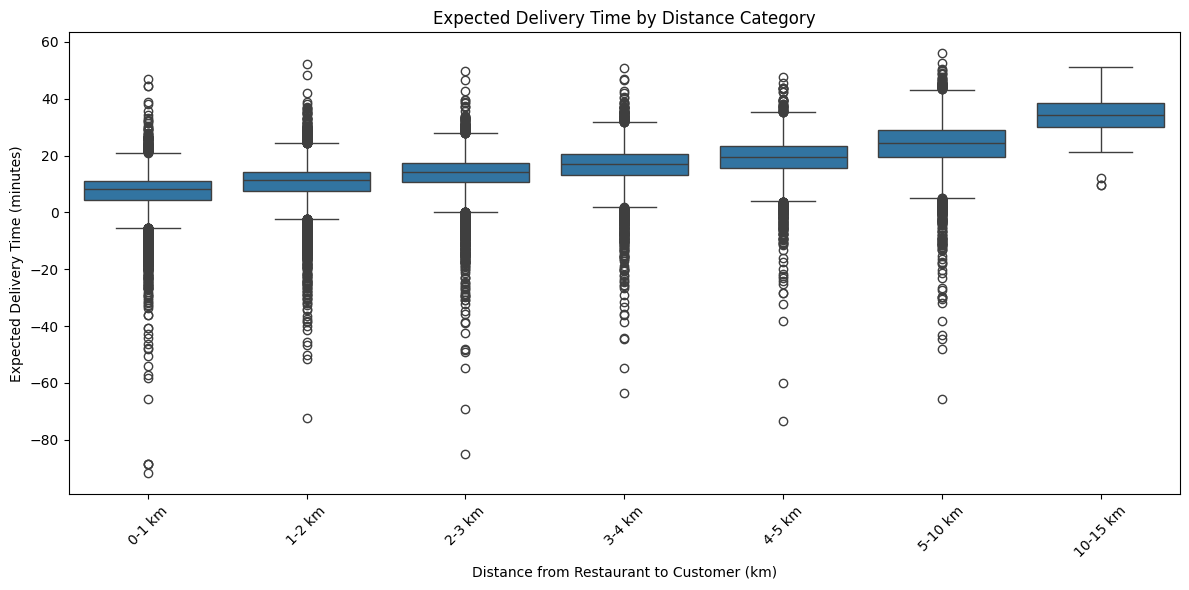

In [53]:
distance_bins = [0, 1, 2, 3, 4, 5, 10, 15]  
distance_labels = ['0-1 km', '1-2 km', '2-3 km', '3-4 km', '4-5 km', '5-10 km', '10-15 km']

df_final['distance_category'] = pd.cut(df_final['distance_km'], bins=distance_bins, labels=distance_labels, right=False)

plt.figure(figsize=(12, 6))
sns.boxplot(x='distance_category', y='actual_timetaken_delivery', data=df_final)
plt.title('Actual Delivery Time by Distance Category')
plt.xlabel('Distance from Restaurant to Customer (km)')
plt.ylabel('Actual Delivery Time (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='distance_category', y='updated_timetaken_delivery', data=df_final)
plt.title('Expected Delivery Time by Distance Category')
plt.xlabel('Distance from Restaurant to Customer (km)')
plt.ylabel('Expected Delivery Time (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [54]:
df_final[(df_final['order_id']==1)][['courier_order_propose_accept','courier_reach_restaurant_accept_order','courier_reach_restaurant_prep','courier_restaurant_prep_pick_order','updated_timetaken_delivery','actual_timetaken_delivery']]

,courier_order_propose_accept,courier_reach_restaurant_accept_order,courier_reach_restaurant_prep,courier_restaurant_prep_pick_order,updated_timetaken_delivery,actual_timetaken_delivery
0,0.166667,4.65,0.116667,0.166667,22.283333,29.116667


In [55]:
df_final['diff'] = df_final['actual_timetaken_delivery'] - df_final['updated_timetaken_delivery']

In [56]:
df_final['diff'].describe(percentiles=[0.25,0.5,0.75,0.9,0.95])

count    64228.000000
mean        -1.533316
std          7.789401
min        -46.333333
25%         -6.200000
50%         -2.616667
75%          1.816667
90%          7.433333
95%         11.916667
max        102.450000
Name: diff, dtype: float64

In [57]:
final_df[final_df['order_id']==244].sort_values(by='order_stage_start')

,log_id,city,order_id,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,task_id
2207,1184,Bucharest,244,1476,motorbike,order_proposed_to_courier,2021-10-15 12:02:13.000,26.037000,44.430168,NaN,NaN,261.629128,NaN,2021-10-15 12:19:55.000,1
2211,1188,Bucharest,244,1476,motorbike,courier_accepts_order,2021-10-15 12:02:21.000,26.039501,44.430428,195.0,NaN,198.431808,NaN,2021-10-15 12:19:33.000,1
2239,1216,Bucharest,244,1476,motorbike,courier_arrived_at_restaurant,2021-10-15 12:04:44.000,26.038919,44.432021,NaN,NaN,16.366310,NaN,2021-10-15 12:18:05.000,1
2258,1235,Bucharest,244,1476,motorbike,courier_picked_up_order,2021-10-15 12:05:53.000,26.038734,44.431645,NaN,528.0,55.181603,1821.367615,2021-10-15 12:17:14.000,1
2481,1458,Bucharest,244,1476,motorbike,courier_arrived_at_customer,2021-10-15 12:18:06.000,26.017851,44.424917,NaN,NaN,NaN,33.305073,2021-10-15 12:17:04.000,1
2485,1462,Bucharest,244,1476,motorbike,courier_delivered_order,2021-10-15 12:18:22.000,26.017686,44.424702,NaN,NaN,NaN,53.974952,NaN,1


In [58]:
df_final[df_final['order_id']==244][['distance_courier_to_restaurant_address','distance_km','total_courier_time','updated_expected_delivery_time','actual_delivery_time']]

,distance_courier_to_restaurant_address,distance_km,total_courier_time,updated_expected_delivery_time,actual_delivery_time
244,0.261629,1.847089,14.916667,2021-10-15 12:23:28,2021-10-15 12:18:06


In [59]:
df_final[['courier_order_propose_accept','courier_reach_restaurant_accept_order','courier_reach_restaurant_prep','courier_restaurant_prep_pick_order','courier_reach_restaurant_pick_order','updated_timetaken_delivery','actual_timetaken_delivery', 'diff']].describe(percentiles=[0.25,0.5,0.75,0.9,0.95])

,courier_order_propose_accept,courier_reach_restaurant_accept_order,courier_reach_restaurant_prep,courier_restaurant_prep_pick_order,courier_reach_restaurant_pick_order,updated_timetaken_delivery,actual_timetaken_delivery,diff
count,64228.000000,64228.000000,64228.000000,64228.000000,64228.000000,64228.000000,64228.000000,64228.000000
mean,0.190104,4.480792,-0.739272,3.987603,4.726876,13.046048,11.512732,-1.533316
std,0.088962,3.899200,7.292776,4.986651,5.121550,8.599941,6.693463,7.789401
min,0.000000,0.000000,-94.783333,0.000000,0.000000,-91.733333,0.000000,-46.333333
25%,0.116667,1.816667,-4.233333,0.933333,1.233333,8.333333,6.783333,-6.200000
50%,0.166667,3.700000,-0.766667,2.283333,3.066667,12.916667,10.216667,-2.616667
75%,0.233333,6.116667,2.783333,5.300000,6.533333,17.883333,14.783333,1.816667
90%,0.316667,9.233333,6.816667,9.550000,10.950000,23.250000,20.050000,7.433333
95%,0.366667,11.666667,10.000000,12.933333,14.477500,26.966667,24.060833,11.916667
max,0.600000,55.233333,100.883333,104.133333,100.716667,56.000000,91.583333,102.450000


In [60]:
late_delivery = df_final[df_final['diff']>0]
df_final['late_delivery'] = np.where(df_final['diff']>0,'late','not late')

In [61]:
late_delivery['courier_reach_restaurant_prep'].describe()

count    21688.000000
mean        -1.494751
std         10.904953
min        -94.783333
25%         -8.016667
50%         -1.983333
75%          4.883333
max        100.883333
Name: courier_reach_restaurant_prep, dtype: float64

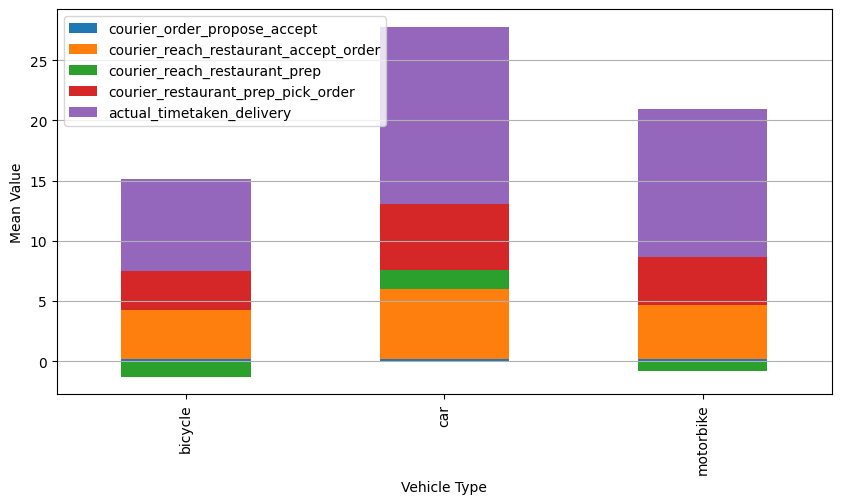

In [62]:
column_means = df_final[['vehicle_type','courier_order_propose_accept','courier_reach_restaurant_accept_order','courier_reach_restaurant_prep','courier_restaurant_prep_pick_order','actual_timetaken_delivery']].groupby('vehicle_type').mean()

grouped_means = column_means.groupby('vehicle_type').mean()

plt.figure(figsize=(10, 5))

grouped_means.plot(kind='bar', stacked=True, ax=plt.gca())

plt.xlabel('Vehicle Type')
plt.ylabel('Mean Value')
plt.grid(axis='y')
plt.show()

In [63]:
grouped_means

,courier_order_propose_accept,courier_reach_restaurant_accept_order,courier_reach_restaurant_prep,courier_restaurant_prep_pick_order,actual_timetaken_delivery
vehicle_type,,,,,
bicycle,0.190650,4.046651,-1.277767,3.269250,7.602380
car,0.183901,5.797764,1.552248,5.481573,14.773868
motorbike,0.190655,4.453582,-0.847720,4.020364,12.244077


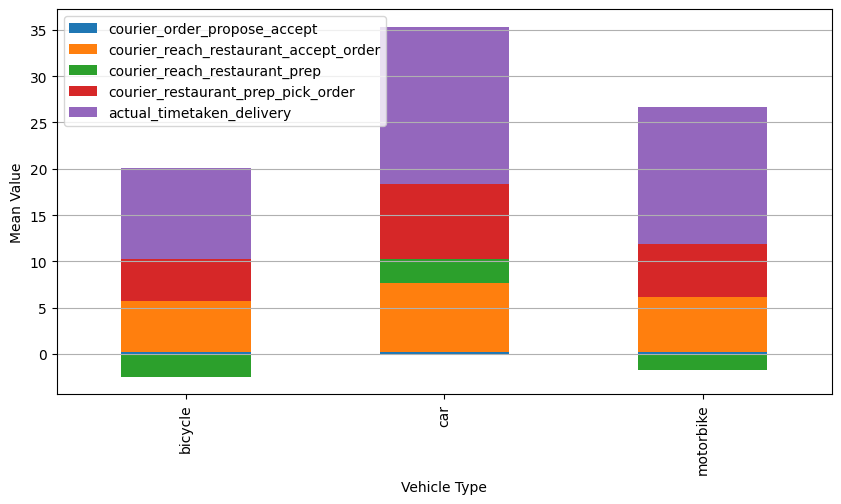

In [64]:
column_means = late_delivery[['vehicle_type','courier_order_propose_accept','courier_reach_restaurant_accept_order','courier_reach_restaurant_prep','courier_restaurant_prep_pick_order','actual_timetaken_delivery']].groupby('vehicle_type').mean()

grouped_means = column_means.groupby('vehicle_type').mean()

plt.figure(figsize=(10, 5))

grouped_means.plot(kind='bar', stacked=True, ax=plt.gca())

plt.xlabel('Vehicle Type')
plt.ylabel('Mean Value')
plt.grid(axis='y')
plt.show()

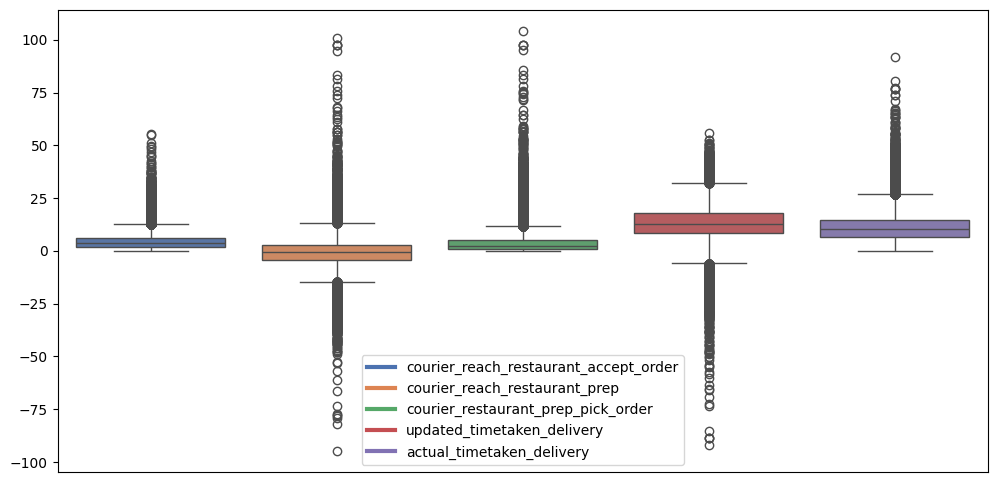

In [65]:
plt.figure(figsize=(12, 6))
a = df_final[['courier_reach_restaurant_accept_order','courier_reach_restaurant_prep','courier_restaurant_prep_pick_order','updated_timetaken_delivery','actual_timetaken_delivery']]
sns.boxplot(data=a, palette="deep")

plt.xticks([])  

colors = sns.color_palette("deep", len(a.columns))  
handles = [plt.Line2D([0], [0], color=color, lw=3) for color in colors]  

plt.legend(handles=handles, labels=list(a.columns), loc='lower center')

plt.show()

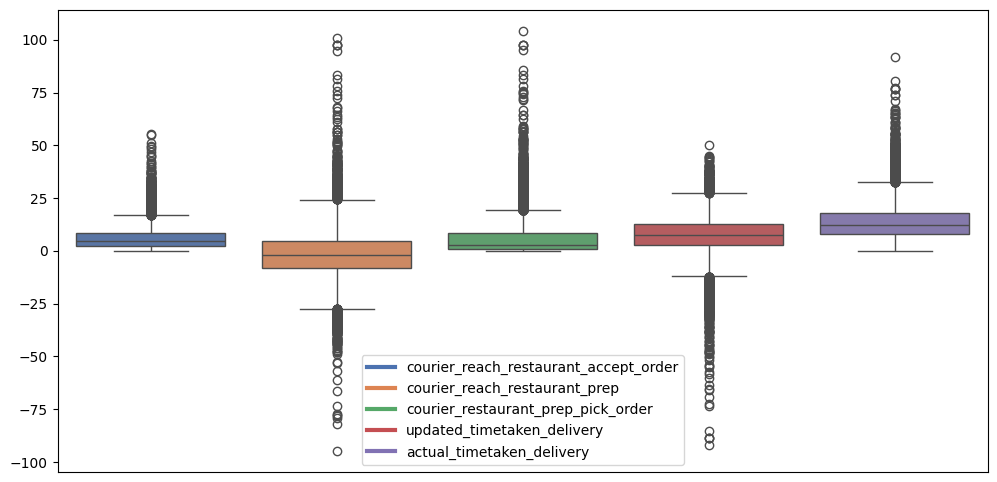

In [66]:
plt.figure(figsize=(12, 6))
a = late_delivery[['courier_reach_restaurant_accept_order','courier_reach_restaurant_prep','courier_restaurant_prep_pick_order','updated_timetaken_delivery','actual_timetaken_delivery']]
sns.boxplot(data=a, palette="deep")

plt.xticks([])  

colors = sns.color_palette("deep", len(a.columns))  
handles = [plt.Line2D([0], [0], color=color, lw=3) for color in colors]  

plt.legend(handles=handles, labels=list(a.columns), loc='lower center')

plt.show()

<Axes: xlabel='courier_reach_restaurant_prep'>

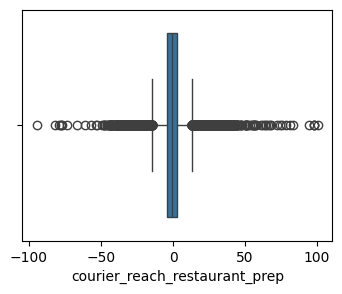

In [67]:
plt.figure(figsize=(4, 3))
sns.boxplot(x='courier_reach_restaurant_prep', data=df_final)

<Axes: xlabel='courier_restaurant_prep_pick_order'>

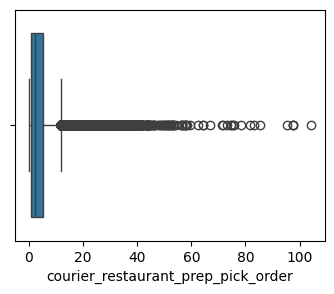

In [68]:
plt.figure(figsize=(4, 3))
a = df_final.copy()
upper_lim = a['courier_reach_restaurant_pick_order'].quantile(.98)
lower_lim = a['courier_reach_restaurant_pick_order'].quantile(.02)
a.loc[(a['courier_reach_restaurant_pick_order'] > upper_lim),'courier_reach_restaurant_pick_order'] = upper_lim
a.loc[(a['courier_reach_restaurant_pick_order'] < lower_lim),'courier_reach_restaurant_pick_order'] = lower_lim

sns.boxplot(x='courier_restaurant_prep_pick_order', data=a)

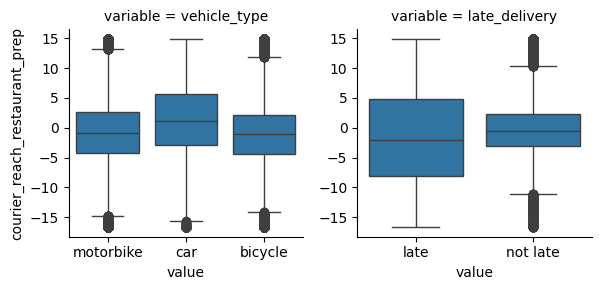

In [69]:
cat = ['vehicle_type','late_delivery']
a = df_final.copy()
upper_lim = a['courier_reach_restaurant_prep'].quantile(.98)
lower_lim = a['courier_reach_restaurant_prep'].quantile(.02)
a.loc[(a['courier_reach_restaurant_prep'] > upper_lim),'courier_reach_restaurant_prep'] = upper_lim
a.loc[(a['courier_reach_restaurant_prep'] < lower_lim),'courier_reach_restaurant_prep'] = lower_lim

p = pd.melt(a, id_vars='courier_reach_restaurant_prep', value_vars=cat)
g = sns.FacetGrid (p, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(boxplot, 'value','courier_reach_restaurant_prep')
g

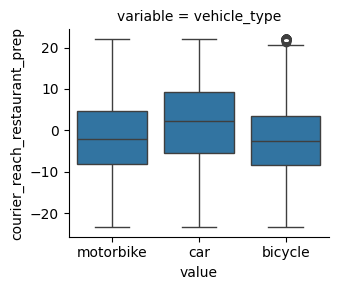

In [70]:
cat = ['vehicle_type']
a = late_delivery.copy()
upper_lim = a['courier_reach_restaurant_prep'].quantile(.98)
lower_lim = a['courier_reach_restaurant_prep'].quantile(.02)
a.loc[(a['courier_reach_restaurant_prep'] > upper_lim),'courier_reach_restaurant_prep'] = upper_lim
a.loc[(a['courier_reach_restaurant_prep'] < lower_lim),'courier_reach_restaurant_prep'] = lower_lim

p = pd.melt(a, id_vars='courier_reach_restaurant_prep', value_vars=cat)
g = sns.FacetGrid (p, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(boxplot, 'value','courier_reach_restaurant_prep')
g

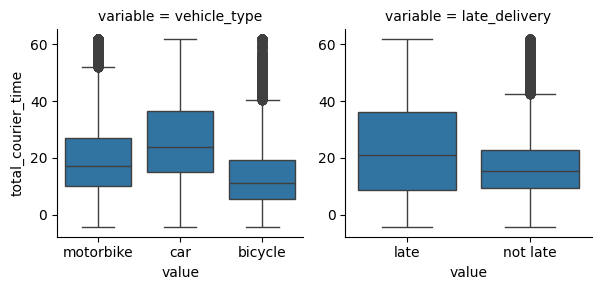

In [71]:
cat = ['vehicle_type','late_delivery']
a = df_final.copy()
upper_lim = a['total_courier_time'].quantile(.98)
lower_lim = a['total_courier_time'].quantile(.02)
a.loc[(a['total_courier_time'] > upper_lim),'total_courier_time'] = upper_lim
a.loc[(a['total_courier_time'] < lower_lim),'total_courier_time'] = lower_lim

p = pd.melt(a, id_vars='total_courier_time', value_vars=cat)
g = sns.FacetGrid (p, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(boxplot, 'value','total_courier_time')
g

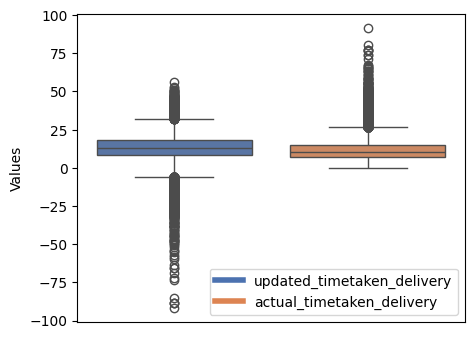

In [72]:
## 

plt.figure(figsize=(5, 4))
a = df_final[['updated_timetaken_delivery','actual_timetaken_delivery']]
sns.boxplot(data=a, palette="deep")

plt.xticks([])  

colors = sns.color_palette("deep", len(a.columns))  
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]  

plt.legend(handles=handles, labels=list(a.columns), loc='lower right')

plt.ylabel('Values')

plt.show()

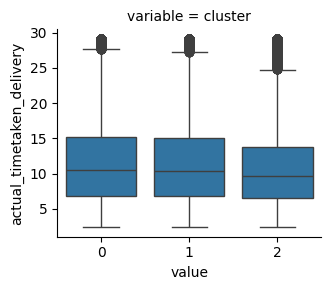

In [73]:
a = df_final.copy()
upper_lim = a['actual_timetaken_delivery'].quantile(.98)
lower_lim = a['actual_timetaken_delivery'].quantile(.02)
a.loc[(a['actual_timetaken_delivery'] > upper_lim),'actual_timetaken_delivery'] = upper_lim
a.loc[(a['actual_timetaken_delivery'] < lower_lim),'actual_timetaken_delivery'] = lower_lim

p = pd.melt(a, id_vars='actual_timetaken_delivery', value_vars='cluster')
g = sns.FacetGrid (p, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(boxplot, 'value','actual_timetaken_delivery')
g

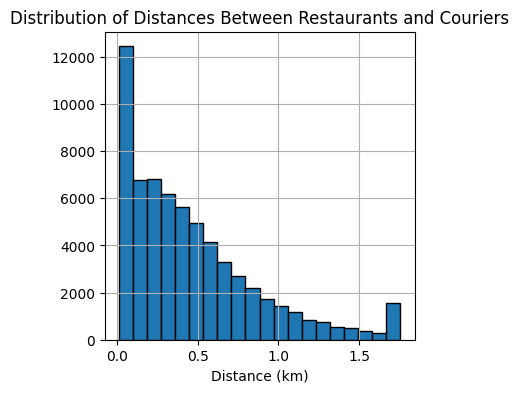

In [74]:
plt.figure(figsize=(4, 4))
a = df_final.copy()
upper_lim = a['distance_courier_to_restaurant_address'].quantile(.98)
lower_lim = a['distance_courier_to_restaurant_address'].quantile(.02)
a.loc[(a['distance_courier_to_restaurant_address'] > upper_lim),'distance_courier_to_restaurant_address'] = upper_lim
a.loc[(a['distance_courier_to_restaurant_address'] < lower_lim),'distance_courier_to_restaurant_address'] = lower_lim

plt.hist(a['distance_courier_to_restaurant_address'], bins=20, edgecolor='black')
plt.title('Distribution of Distances Between Restaurants and Couriers')
plt.xlabel('Distance (km)')
plt.grid(True)
plt.show()

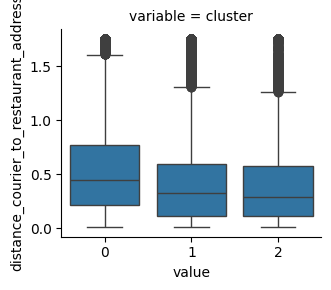

In [75]:
## distance between the courier and restaurant cluster 1 is very less

a = df_final.copy()
upper_lim = a['distance_courier_to_restaurant_address'].quantile(.98)
lower_lim = a['distance_courier_to_restaurant_address'].quantile(.02)
a.loc[(a['distance_courier_to_restaurant_address'] > upper_lim),'distance_courier_to_restaurant_address'] = upper_lim
a.loc[(a['distance_courier_to_restaurant_address'] < lower_lim),'distance_courier_to_restaurant_address'] = lower_lim
p = pd.melt(a, id_vars='distance_courier_to_restaurant_address', value_vars='cluster')
g = sns.FacetGrid (p, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(boxplot, 'value','distance_courier_to_restaurant_address')
g

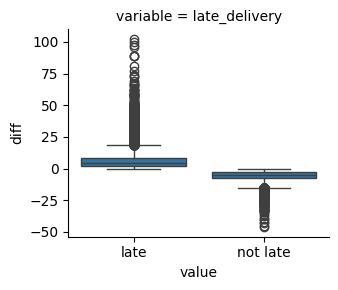

In [76]:
a = df_final.copy()
p = pd.melt(a, id_vars='diff', value_vars='late_delivery')
g = sns.FacetGrid (p, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(boxplot, 'value','diff')
g

In [77]:
df_final[['cluster','courier_reach_restaurant_accept_order','courier_reach_restaurant_prep','courier_restaurant_prep_pick_order','courier_reach_restaurant_pick_order']].groupby('cluster').describe(percentiles=[0.25,0.5,0.75,0.9,0.95]).transpose()

cluster                                                 0             1   
courier_reach_restaurant_accept_order count  22306.000000  26994.000000  \
                                      mean       4.726788      4.412563   
                                      std        3.650284      4.030017   
                                      min        0.016667      0.000000   
                                      25%        2.300000      1.583333   
                                      50%        3.983333      3.600000   
                                      75%        6.250000      6.100000   
                                      90%        9.200000      9.283333   
                                      95%       11.466667     11.772500   
                                      max       48.316667     55.233333   
courier_reach_restaurant_prep         count  22306.000000  26994.000000   
                                      mean      -0.460662     -0.889349   
                                      std        7.443705      7.317860   
                                      min      -81.866667    -94.783333   
                                      25%       -4.116667     -4.350000   
                                      50%       -0.616667     -0.816667   
                                      75%        3.183333      2.666667   
                                      90%        7.408333      6.633333   
                                      95%       10.633333      9.700000   
                                      max       97.566667    100.883333   
courier_restaurant_prep_pick_order    count  22306.000000  26994.000000   
                                      mean       3.920415      4.090908   
                                      std        5.066590      5.019667   
                                      min        0.000000      0.000000   
                                      25%        0.850000      0.983333   
                                      50%        2.100000      2.400000   
                                      75%        5.183333      5.483333   
                                      90%        9.600000      9.650000   
                                      95%       13.083333     12.916667   
                                      max       97.566667    104.133333   
courier_reach_restaurant_pick_order   count  22306.000000  26994.000000   
                                      mean       4.381076      4.980258   
                                      std        4.917151      5.347074   
                                      min        0.000000      0.000000   
                                      25%        1.133333      1.300000   
                                      50%        2.683333      3.300000   
                                      75%        6.066667      6.866667   
                                      90%       10.316667     11.416667   
                                      95%       13.662500     15.183333   
                                      max       82.783333    100.716667   

cluster                                                 2  
courier_reach_restaurant_accept_order count  14928.000000  
                                      mean       4.236590  
                                      std        3.997448  
                                      min        0.016667  
                                      25%        1.412500  
                                      50%        3.383333  
                                      75%        5.850000  
                                      90%        9.200000  
                                      95%       11.766667  
                                      max       55.066667  
courier_reach_restaurant_prep         count  14928.000000  
                                      mean      -0.884202  
                                      std        7.001980  
                                      min      -77.516667  
                        

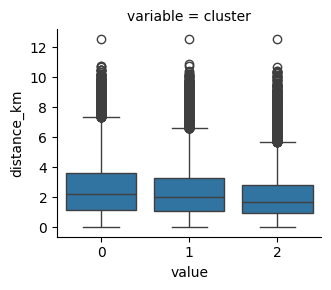

In [78]:
## distance between restaurant and delivery address

p = pd.melt(df, id_vars='distance_km', value_vars='cluster')
g = sns.FacetGrid (p, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(boxplot, 'value','distance_km')
g

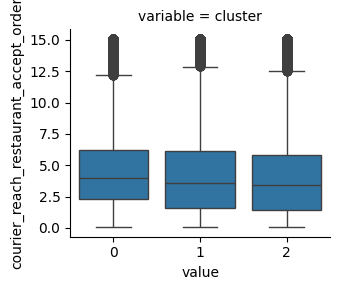

In [79]:
## courier reaching restaurant after accepting order

a = df_final.copy()
upper_lim = a['courier_reach_restaurant_accept_order'].quantile(.98)
lower_lim = a['courier_reach_restaurant_accept_order'].quantile(.02)
a.loc[(a['courier_reach_restaurant_accept_order'] > upper_lim),'courier_reach_restaurant_accept_order'] = upper_lim
a.loc[(a['courier_reach_restaurant_accept_order'] < lower_lim),'courier_reach_restaurant_accept_order'] = lower_lim

p = pd.melt(a, id_vars='courier_reach_restaurant_accept_order', value_vars='cluster')
g = sns.FacetGrid (p, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(boxplot, 'value','courier_reach_restaurant_accept_order')
g

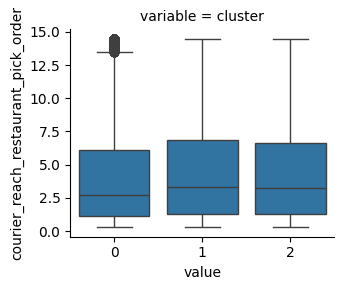

In [80]:
## courier pick order time is higher for cluster 1 when reaching the restaurant

a = df_final.copy()
upper_lim = a['courier_reach_restaurant_pick_order'].quantile(.95)
lower_lim = a['courier_reach_restaurant_pick_order'].quantile(.05)
a.loc[(a['courier_reach_restaurant_pick_order'] > upper_lim),'courier_reach_restaurant_pick_order'] = upper_lim
a.loc[(a['courier_reach_restaurant_pick_order'] < lower_lim),'courier_reach_restaurant_pick_order'] = lower_lim
p = pd.melt(a, id_vars='courier_reach_restaurant_pick_order', value_vars='cluster')
g = sns.FacetGrid (p, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(boxplot, 'value','courier_reach_restaurant_pick_order')
g

In [81]:
df_final['day_of_week']= df_final['order_promised_delivery'].dt.day_name()

  day_of_week  average_delivery_time  average_wait_time   
1      Monday              11.242173           4.820216  \
5     Tuesday              11.558219           4.866759   
6   Wednesday              11.677248           4.746851   
4    Thursday              11.679429           4.687650   
0      Friday              11.689386           4.684120   
2    Saturday              11.334758           4.719066   
3      Sunday              11.315263           4.552174   

   frequency_of_early_arrivals  order_volume  
1                    -1.088634          9419  
5                    -0.965595          9239  
6                    -0.824799          9881  
4                    -0.367136         10359  
0                    -0.706871         10315  
2                    -1.081143          7912  
3                    -0.172569          8348  


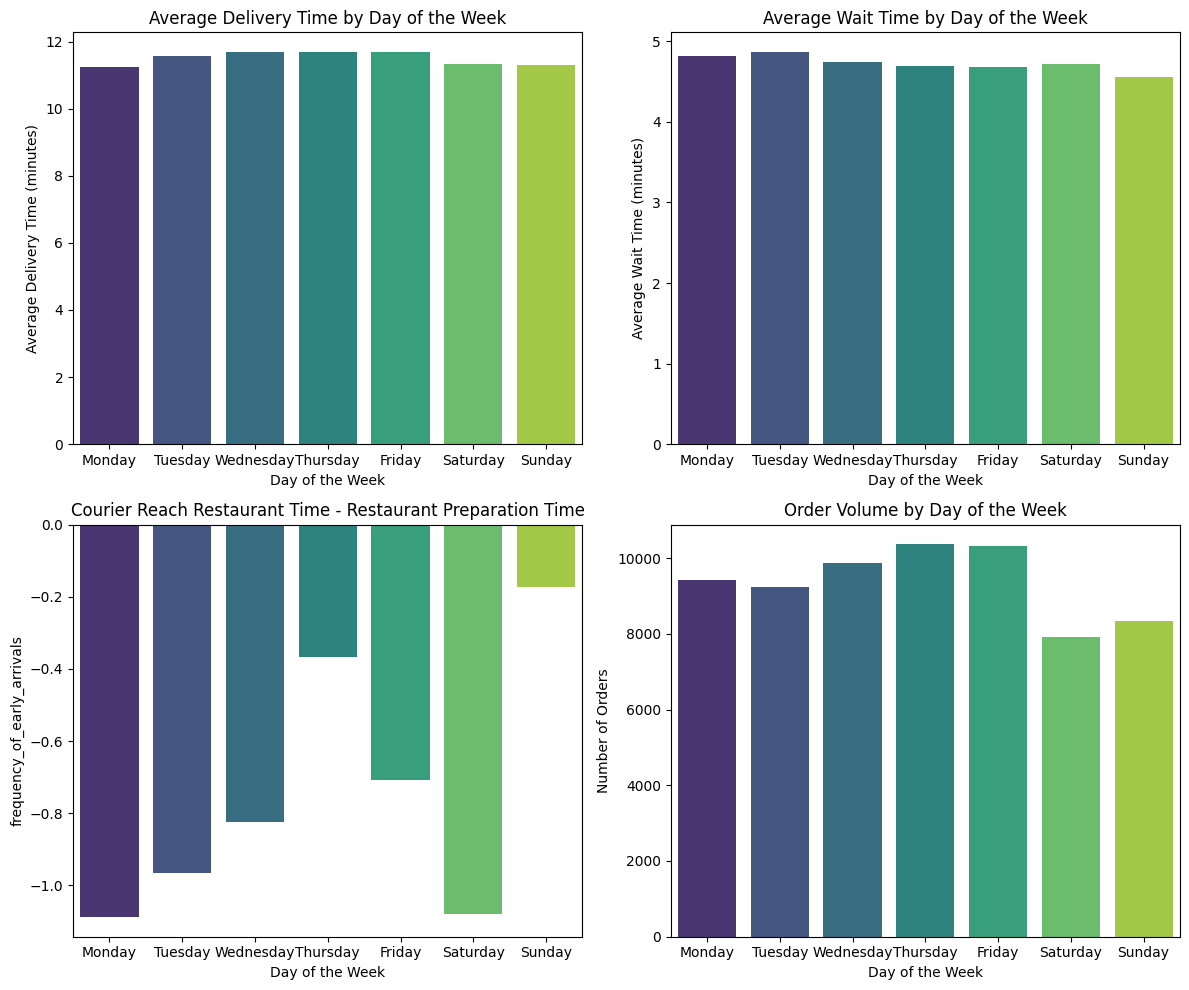

In [82]:
metrics_by_day = df_final.groupby('day_of_week').agg(
    average_delivery_time=('actual_timetaken_delivery', 'mean'),
    average_wait_time=('courier_reach_restaurant_pick_order', 'mean'),
    frequency_of_early_arrivals=('courier_reach_restaurant_prep', 'mean'),
    order_volume=('order_id', 'nunique')
).reset_index()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
metrics_by_day['day_of_week'] = pd.Categorical(metrics_by_day['day_of_week'], categories=day_order, ordered=True)
metrics_by_day = metrics_by_day.sort_values('day_of_week')

print(metrics_by_day)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.barplot(data=metrics_by_day, x='day_of_week', y='average_delivery_time', palette='viridis')
plt.title('Average Delivery Time by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delivery Time (minutes)')

plt.subplot(2, 2, 2)
sns.barplot(data=metrics_by_day, x='day_of_week', y='average_wait_time', palette='viridis')
plt.title('Average Wait Time by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Wait Time (minutes)')

plt.subplot(2, 2, 3)
sns.barplot(data=metrics_by_day, x='day_of_week', y='frequency_of_early_arrivals', palette='viridis')
plt.title('Courier Reach Restaurant Time - Restaurant Preparation Time')
plt.xlabel('Day of the Week')

plt.subplot(2, 2, 4)
sns.barplot(data=metrics_by_day, x='day_of_week', y='order_volume', palette='viridis')
plt.title('Order Volume by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')

plt.tight_layout()
plt.show()

In [83]:
df_final[df_final['courier_reach_restaurant_prep'] < -10][['order_id','courier_order_propose_accept','courier_reach_restaurant_accept_order','courier_reach_restaurant_prep','courier_restaurant_prep_pick_order']]

,order_id,courier_order_propose_accept,courier_reach_restaurant_accept_order,courier_reach_restaurant_prep,courier_restaurant_prep_pick_order
30,31,0.166667,4.216667,-14.683333,0.916667
48,49,0.150000,4.433333,-10.316667,1.100000
57,58,0.233333,5.566667,-22.233333,1.350000
65,66,0.250000,4.150000,-19.516667,1.133333
105,107,0.100000,0.933333,-12.233333,1.166667
...,...,...,...,...,...
65511,65519,0.133333,3.233333,-14.500000,0.550000
65520,65528,0.100000,5.433333,-34.450000,0.250000
65550,65558,0.233333,0.250000,-17.100000,2.066667
65557,65565,0.216667,9.250000,-14.783333,2.483333


In [84]:
final_df[final_df['order_id']==65519]

,log_id,city,order_id,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,task_id
384518,384519,Bucharest,65519,2766,motorbike,order_proposed_to_courier,2021-11-18 23:53:06.000,26.175468,44.419049,NaN,NaN,251.653853,NaN,2021-11-19 00:04:58.000,1
384519,384520,Bucharest,65519,2766,motorbike,courier_accepts_order,2021-11-18 23:53:14.000,26.175457,44.419058,111.0,NaN,250.526559,NaN,2021-11-19 00:04:58.000,1
384529,384530,Bucharest,65519,2766,motorbike,courier_arrived_at_restaurant,2021-11-18 23:56:28.000,26.172535,44.419234,NaN,NaN,53.395179,NaN,2021-11-19 00:04:58.000,1
384597,384598,Bucharest,65519,2766,motorbike,courier_picked_up_order,2021-11-19 00:11:31.000,26.172282,44.419635,NaN,256.0,14.947790,921.155306,2021-11-19 00:17:10.000,1
384620,384621,Bucharest,65519,2766,motorbike,courier_arrived_at_customer,2021-11-19 00:18:17.000,26.177613,44.412266,NaN,NaN,NaN,12.536981,2021-11-19 00:18:17.000,1
384626,384627,Bucharest,65519,2766,motorbike,courier_delivered_order,2021-11-19 00:20:52.000,26.177501,44.412375,NaN,NaN,NaN,16.507646,NaN,1


In [85]:
df[df['order_id']==65519]

,order_id,customer_id,restaurant_id,city,restaurant_address_lng,restaurant_address_lat,delivery_address_lng,delivery_address_lat,order_state,order_promised_delivery,restaurant_finished_preparation,distance_km,cluster
67919,65519,944,1406,Bucharest,26.172439,44.419709,26.177464,44.412229,delivered,2021-11-19 00:11:42+00:00,2021-11-19 00:10:58+00:00,0.922537,1


<Axes: title={'center': 'Distribution of Courier Wait Times (minutes)'}, ylabel='Frequency'>

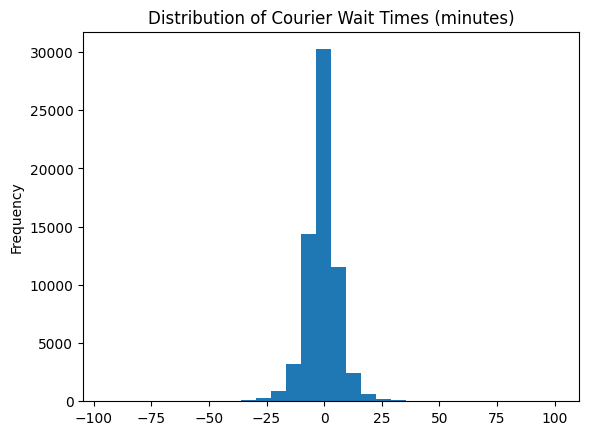

In [86]:
df_final['wait_time'] = (df_final['courier_reach_restaurant'] - df_final['restaurant_finished_preparation']).dt.total_seconds() / 60  # in minutes

avg_wait_time_by_day = df_final.groupby('day_of_week')['wait_time'].mean().sort_values()

df_final['courier_reach_restaurant_prep'].plot(kind='hist', bins=30, title="Distribution of Courier Wait Times (minutes)")

In [87]:
df_final['courier_reach_restaurant_prep'].describe()

count    64228.000000
mean        -0.739272
std          7.292776
min        -94.783333
25%         -4.233333
50%         -0.766667
75%          2.783333
max        100.883333
Name: courier_reach_restaurant_prep, dtype: float64

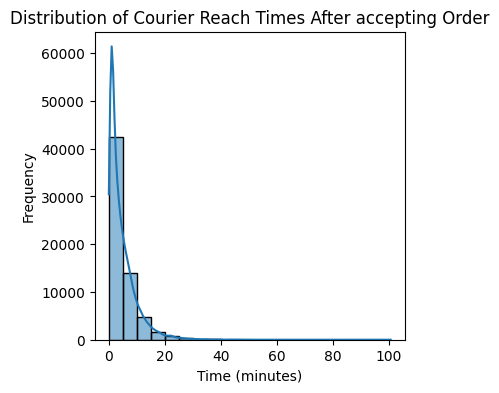

In [88]:
plt.figure(figsize=(4, 4))
sns.histplot(df_final['courier_reach_restaurant_pick_order'], bins=20, kde=True)
plt.title("Distribution of Courier Reach Times After accepting Order")
plt.xlabel("Time (minutes)")
plt.ylabel("Frequency")
plt.show()


In [90]:
df_final[df_final['courier_reach_restaurant_prep']<-5]

,order_id,customer_id,restaurant_id,city,restaurant_address_lng,restaurant_address_lat,delivery_address_lng,delivery_address_lat,order_state,order_promised_delivery,...,courier_accept_order_restaurant_prep,courier_reach_restaurant_prep,courier_restaurant_prep_pick_order,courier_reach_restaurant_pick_order,total_courier_time,distance_category,diff,late_delivery,day_of_week,wait_time
7,8,9244,57,Bucharest,26.020710,44.419075,26.031505,44.419433,delivered,2021-10-15 08:42:51,...,10.450000,-5.250000,0.516667,5.766667,5.650000,0-1 km,-4.333333,not late,Friday,-5.250000
12,13,14525,710,Bucharest,26.101437,44.437441,26.052193,44.455688,delivered,2021-10-15 09:28:24,...,9.550000,-5.650000,13.133333,18.783333,24.866667,4-5 km,-2.200000,not late,Friday,-5.650000
20,21,2181,893,Bucharest,26.096648,44.448157,26.091172,44.482878,delivered,2021-10-15 10:12:53,...,10.950000,-7.050000,0.583333,7.633333,13.733333,3-4 km,-3.850000,not late,Friday,-7.050000
28,29,34314,1314,Bucharest,26.114601,44.460855,26.134367,44.441001,delivered,2021-10-15 10:50:24,...,7.666667,-5.333333,0.983333,6.316667,10.716667,2-3 km,2.516667,late,Friday,-5.333333
30,31,5304,90,Bucharest,26.095731,44.439653,26.093398,44.436414,delivered,2021-10-15 10:34:40,...,18.900000,-14.683333,0.916667,15.600000,-5.033333,0-1 km,11.866667,late,Friday,-14.683333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65550,65558,2065,826,Bucharest,26.107074,44.419513,26.171734,44.433316,delivered,2021-11-19 01:38:34,...,17.350000,-17.100000,2.066667,19.166667,1.083333,5-10 km,11.650000,late,Friday,-17.100000
65557,65565,24826,1106,Bucharest,26.051774,44.451095,26.053644,44.472345,delivered,2021-11-19 01:52:38,...,24.033333,-14.783333,2.483333,17.266667,6.083333,2-3 km,7.116667,late,Friday,-14.783333
65564,65572,13174,1071,Bucharest,26.087019,44.433083,26.063272,44.427830,delivered,2021-11-19 02:05:20,...,8.050000,-7.950000,1.700000,9.650000,0.166667,1-2 km,-0.500000,not late,Friday,-7.950000
65567,65575,3408,1211,Bucharest,26.139071,44.380931,26.139108,44.374289,delivered,2021-11-19 02:56:01,...,22.916667,-18.366667,0.650000,19.016667,-9.283333,0-1 km,13.700000,late,Friday,-18.366667


In [91]:
final_df[final_df['order_id']==65575]

,log_id,city,order_id,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,task_id
384907,384908,Bucharest,65575,1422,car,order_proposed_to_courier,2021-11-19 02:42:16.000,26.124333,44.395213,NaN,NaN,1974.322467,NaN,2021-11-19 02:57:02.000,1
384908,384909,Bucharest,65575,1422,car,courier_accepts_order,2021-11-19 02:42:23.000,26.124330,44.395213,218.0,NaN,1974.464044,NaN,2021-11-19 02:56:39.000,1
384910,384911,Bucharest,65575,1422,car,courier_arrived_at_restaurant,2021-11-19 02:46:56.000,26.139011,44.380919,NaN,NaN,4.954335,NaN,2021-11-19 02:54:56.000,1
384924,384925,Bucharest,65575,1422,car,courier_picked_up_order,2021-11-19 03:05:57.000,26.138959,44.381025,NaN,226.0,13.736468,749.525421,2021-11-19 03:11:27.000,1
384925,384926,Bucharest,65575,1422,car,courier_arrived_at_customer,2021-11-19 03:09:43.000,26.139349,44.374166,NaN,NaN,NaN,23.550025,2021-11-19 03:09:43.000,1
384926,384927,Bucharest,65575,1422,car,courier_delivered_order,2021-11-19 03:10:45.000,26.139166,44.374189,NaN,NaN,NaN,12.044015,NaN,1


In [92]:
df_final[df_final['order_id']==65575]['restaurant_finished_preparation']

65567   2021-11-19 03:05:18
Name: restaurant_finished_preparation, dtype: datetime64[ns]